In [15]:
!pip install googletrans

In [20]:
import os
import sys
import pandas as pd
import googletrans
from googletrans import Translator
%matplotlib inline
import matplotlib.pyplot as plt

In [18]:
DIR_PATH = r"C:\Users\gabi9\Desktop\Dev\python_dev\elections"
CALPI = "calpi"
SETTELMENT = "settelments"
translator = Translator()



def get_data(agg_type, num):
    """returns dataframe of the requested csv
    
    parameters
    ----------
    agg_type - aggregation type of the csv needed
    num - election number
    
    return
    ------
    DataFrame
    """
    if type(num) is not str:
        num = str(num)
    
    ROOT_PATH = os.path.abspath(os.getcwd())
    path = os.path.join(ROOT_PATH,num+agg_type+".xlsx")
    df = pd.read_excel(path)
    df_en = df.copy()
    
    df_en.rename(columns=lambda x: translator.translate(x,dest='en',src='he').text, inplace=True)
    return df_en
    

Index(['City name', 'City icon', 'Number of polling', 'Abazaab', 'Voters',
       'Unfit', 'Kosher', 'Truth', 'third', 'Dem', 'Dated', 'Seventh', 'Zee',
       'pure', 'It', 'Vicious strain', 'Teva', 'The', 'XVII', 'yen',
       'Distributor', 'about', 'Dick', 'To', 'forgave', 'Meretz', 'V', 'Nez',
       'Yes', 'Hawk', 'candle', 'Estate', 'Yes', 'Nn', 'Mouth', 'Paz',
       'According to', 'Jug', 'Penn', 'Pecs', 'Hee', 'Court', 'Caza', 'Fleet',
       'K.', 'Ki', 'nest', 'Volume', 'R', 'Shas'],
      dtype='object')


Text(0.5, 1.0, 'Company profit per month')

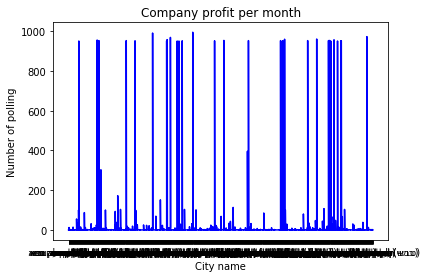

In [21]:
df21=get_data(CALPI,21) 
plt.figure(1)
plt.plot(df21['City name'], df21['Number of polling'], color='b')
plt.xlabel('City name')
plt.ylabel('Number of polling')
plt.title('')